In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [13]:
df = pd.read_csv("combined_results.csv")

metric = "CRPS"
df = df[df["metric"] == metric]
df = df[df["value"] >= 0].copy()
#df = df[df['suite_id'] == 336]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor', 'LinearRegressor', 'LogisticRegression' , 'RandomForestClassifier', 'RandomForestRegressor', 'LGBMClassifier', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'DGBT', 'DRF'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LinearRegressor': 'Linear Regression',
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

Split 'gower_split': baseline CRPS per task:
 task_id
361093      0.021535
361094      0.549592
361096      0.071795
361097      4.169966
361098      0.019716
361099      0.297168
361101      0.200483
361102      0.137863
361103      0.203991
361104      0.086659
361287      0.013209
361288      1.144239
361289    233.140307
361291      1.572152
361292      0.319973
361293      1.116300
361294      0.165852
dtype: float64
Split 'gower_split': overall lowest CRPS = 0.013208833



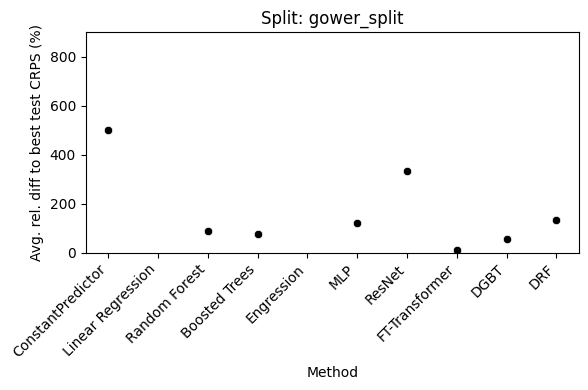

Split 'kmedoids_split': baseline CRPS per task:
 task_id
361093      0.024336
361094      0.805446
361096      0.066911
361097      4.250621
361098      0.013145
361099      0.264383
361101      0.160131
361102      0.098293
361103      0.218740
361104      0.006256
361287      0.012857
361288      1.187931
361289    227.409469
361291      1.549828
361292      0.302130
361293      1.065122
361294      0.104824
dtype: float64
Split 'kmedoids_split': overall lowest CRPS = 0.006256445



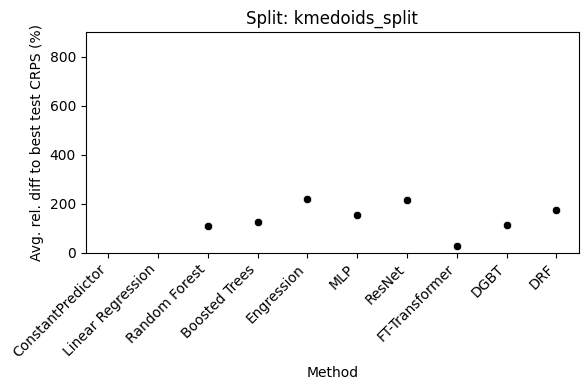

Split 'umap_split': baseline CRPS per task:
 task_id
361072      1.054257
361073      2.467087
361074      0.001127
361076      0.390128
361077      0.000086
361078      0.161859
361079      0.283058
361080      0.127918
361081      0.012498
361082      0.420943
361083      0.201972
361084      0.124743
361085      0.010586
361086      0.054934
361087      0.075374
361088      0.295254
361093      0.183040
361094      0.059287
361096      0.057157
361097      3.440862
361098      0.048229
361099      0.203059
361101      0.191507
361102      0.121352
361103      0.220216
361104      0.028693
361279      0.012295
361280      1.237311
361281      1.626420
361287      0.012080
361288      0.913870
361289    205.625645
361291      1.688195
361292      0.324178
361293      1.043999
361294      0.054934
dtype: float64
Split 'umap_split': overall lowest CRPS = 8.63e-05



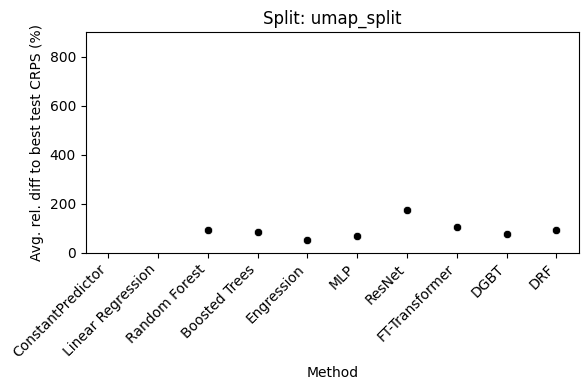

Split 'mahalanobis_split': baseline CRPS per task:
 task_id
361072    2.124565
361073    0.935149
361074    0.001413
361076    0.391615
361077    0.000115
361078    0.140527
361079    0.383502
361080    0.152763
361081    0.070298
361082    0.399360
361083    0.219504
361084    0.122324
361085    0.017783
361086    0.119215
361087    0.140730
361088    0.608691
361279    0.014521
361280    1.165515
361281    1.688491
dtype: float64
Split 'mahalanobis_split': overall lowest CRPS = 0.000115155



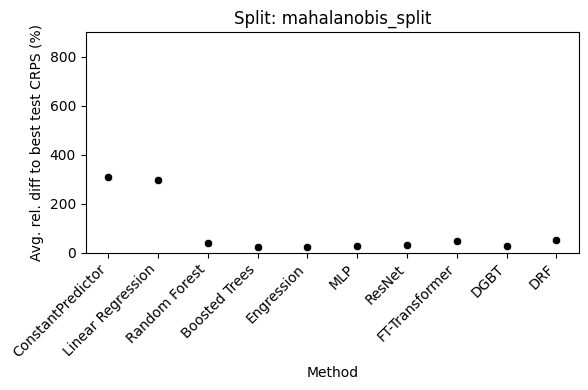

Split 'kmeans_split': baseline CRPS per task:
 task_id
361072    2.110439
361073    2.166463
361074    0.001096
361076    0.367232
361077    0.000114
361078    0.131007
361079    0.294935
361080    0.161137
361081    0.071335
361082    0.301832
361083    0.230019
361084    0.100988
361085    0.014248
361086    0.104729
361087    0.116658
361088    0.709287
361279    0.014390
361280    1.069203
361281    1.666730
dtype: float64
Split 'kmeans_split': overall lowest CRPS = 0.000114444



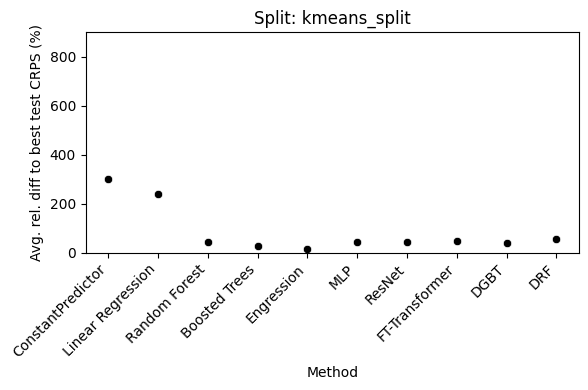

Split 'spatial_depth_split': baseline CRPS per task:
 task_id
361072    2.571273
361073    0.917897
361074    0.001253
361076    0.392900
361077    0.000113
361078    0.138547
361079    0.384593
361080    0.157022
361081    0.046099
361082    0.395713
361083    0.217773
361085    0.017773
361086    0.124334
361087    0.153271
361088    0.595162
361279    0.014535
361280    1.157940
361281    1.682539
dtype: float64
Split 'spatial_depth_split': overall lowest CRPS = 0.000112997



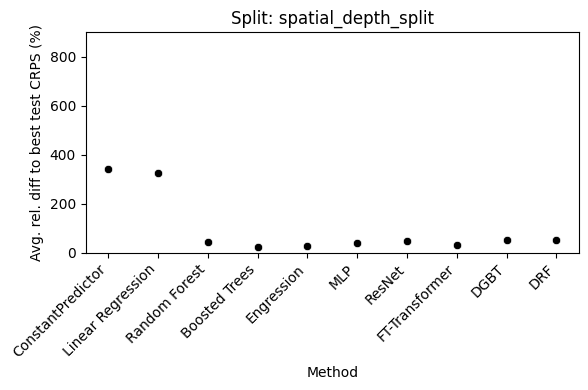

In [14]:
outdir = os.path.join('PICTURES', metric.lower())
os.makedirs(outdir, exist_ok=True)

for split in splits:
    sub = df[df["split_method"] == split]
    if sub.empty:
        continue

    table = sub.pivot(
        index="model",
        columns="task_id",
        values="value"
    )

    baseline = table.min(axis=0)
    print(f"Split '{split}': baseline CRPS per task:\n", baseline)
    print(f"Split '{split}': overall lowest CRPS = {baseline.min()}\n")

    rel = (table - baseline) / baseline

    summary = pd.DataFrame({
        "Mean": rel.mean(axis=1),
        "Median": rel.median(axis=1),
        "Std": rel.std(axis=1)
    }).reset_index().rename(columns={"model": "Method"})

    summary["Method"] = pd.Categorical(
        summary["Method"],
        categories=method_order,
        ordered=True
    )
    summary = summary.sort_values("Method")
    summary["Method"] = summary["Method"].astype(str).map(rename_map).fillna(summary["Method"].astype(str))

    summary["Mean"] = 100 * summary["Mean"]

    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=summary, x="Method", y="Mean", color='black')
    plt.xlabel("Method")
    plt.ylabel("Avg. rel. diff to best test CRPS (%)")
    plt.title(f"Split: {split}")
    plt.ylim(0, 900)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    fname = f"{split}_relative_diff_{metric}.png"
    plt.savefig(os.path.join(outdir, fname), bbox_inches='tight')
    plt.show()




In [10]:
df = df[df["metric"] == "CRPS"]
df = df[df["value"] >= 0].copy()


df = df[df["split_method"] != "random_split"]


=== RAW relative_difference sample ===
       split_method  task_id              model       value  baseline  \
450     gower_split   361093                DRF    0.334312  0.021535   
451     gower_split   361093               DGBT    0.024720  0.021535   
452  kmedoids_split   361093                DRF    0.316729  0.024336   
453  kmedoids_split   361093               DGBT    0.024336  0.024336   
454      umap_split   361093                DRF    0.811470  0.183040   
455      umap_split   361093               DGBT    0.422174  0.183040   
461      umap_split   361093    LinearRegressor    0.674186  0.183040   
463      umap_split   361093  ConstantPredictor    0.800697  0.183040   
465  kmedoids_split   361093    LinearRegressor    0.256131  0.024336   
467  kmedoids_split   361093  ConstantPredictor    0.341237  0.024336   
469     gower_split   361093    LinearRegressor    0.313598  0.021535   
471     gower_split   361093  ConstantPredictor    0.370604  0.021535   
481     gow

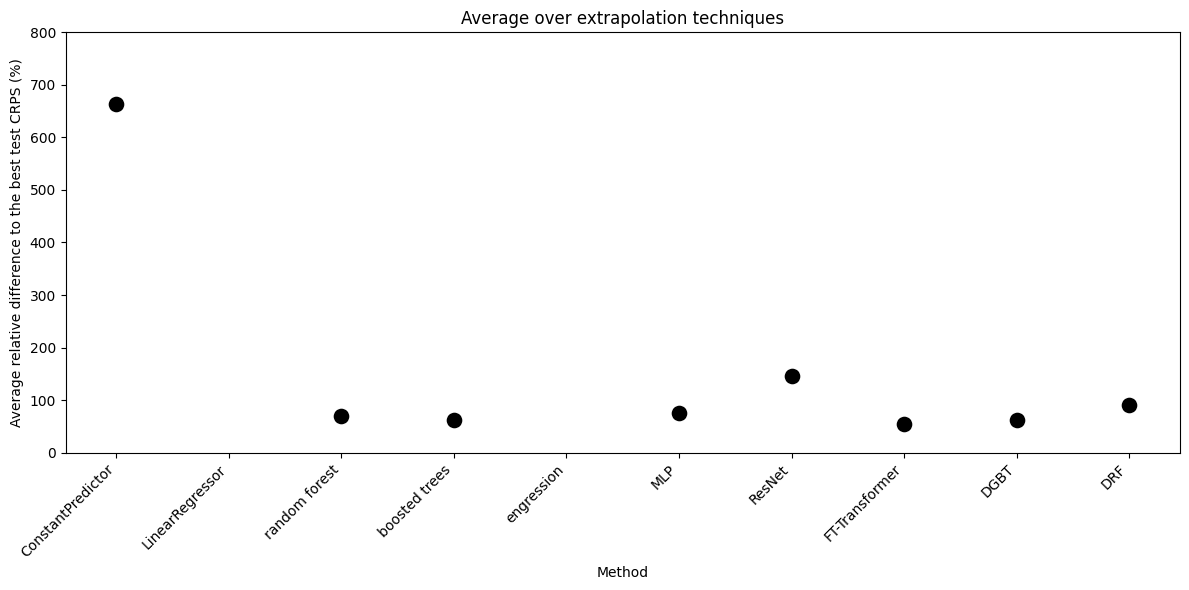

In [12]:
df["baseline"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform("min")
)

df["relative_difference"] = (df["value"] - df["baseline"]) / df["baseline"]

print("\n=== RAW relative_difference sample ===")
print(df[['split_method','task_id','model','value','baseline','relative_difference']].head(20))

print("\n=== per-model relative_difference summary ===")
print(df.groupby('model')['relative_difference']
        .agg(count='count', mean='mean', min='min', max='max')
        .sort_values('mean', ascending=False)
     )

print("\n=== model appearance counts ===")
print(df.groupby('model')['relative_difference']
        .count()
        .sort_values(ascending=False)
     )

# 3) Compute overall mean per model
# --- assume df already has 'relative_difference' computed and filtered ---

# 1) Compute overall average per raw model name
overall = (
    df
    .groupby('model')['relative_difference']
    .mean()
    .reset_index(name='Mean')
)
overall['Mean'] *= 100  # to percent

# 2) Enforce complete ordering on the raw model keys
method_order = [
    'ConstantPredictor', 'LinearRegressor',
    'RandomForestClassifier', 'RandomForestRegressor',
    'LGBMClassifier', 'LGBMRegressor', 'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'DGBT', 'DRF'
]
overall = overall.set_index('model').reindex(method_order).reset_index()

# 3) Map to display names
rename_map = {
    'RandomForestClassifier':'random forest',
    'RandomForestRegressor':'random forest',
    'LGBMClassifier':       'boosted trees',
    'LGBMRegressor':        'boosted trees',
    'Engression':           'engression',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'DGBT':                 'DGBT',
    'DRF':                  'DRF',
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])


plt.figure(figsize=(12,6))
sns.scatterplot(data=overall, x='Method', y='Mean', color='black', s=150)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average relative difference to the best test CRPS (%)')
plt.xlabel('Method')
plt.title('Average over extrapolation techniques')
plt.ylim(0, 800)
plt.tight_layout()

os.makedirs('PICTURES', exist_ok=True)
plt.savefig('PICTURES/average_over_extrapolation_techniques_CRPS.png', bbox_inches='tight')
plt.show()
